# Goals

This notebook has three main sections, the first one is a referesher on the ARIMA models, the second one deals with Fourier analysis and the final one is spectral analysis. Section 1 and 3 contain no exercises while section 2 contains a few exercises.

# Section 1:
## Reminder: ARIMA models and SARIMAX
AR and MA models can be combined with taking differences to give the **ARIMA(p, d, q)** series of models. Last week, we introduced the **tsa.statespace.SARIMAX* method implemented in *statsmodel*: https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

The SARIMAX dunction takes as input the pandas dataframe *df* with the data, and then two tuples specifying the *order* and the *seasonal_order* parameters for the model. 

In [1]:
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
series = read_excel('BuildingMaterials.xls', sheet_name='Data', header=0, index_col=0, parse_dates=True)
series.index.freq = 'MS'

mod = sm.tsa.statespace.SARIMAX(series, order=(1,1,1), seasonal_order=(0,1,1,12))
results = mod.fit(disp=False)
print(results.summary())

<ipython-input-2-daaa4d810b68>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  series = read_excel('BuildingMaterials.xls', sheet_name='Data', header=0, index_col=0, parse_dates=True)


                                     SARIMAX Results                                      
Dep. Variable:                         Production   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1030.968
Date:                            Mon, 13 May 2024   AIC                           2069.936
Time:                                    18:10:43   BIC                           2084.054
Sample:                                09-01-1986   HQIC                          2075.617
                                     - 09-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1172      0.134     -0.877      0.380      -0.379       0.145
ma.L1         -0.3691      0.120   

The cell below uses the *itertools* python library to create all possible combinations of *p*, *d* and *q* triplets: https://docs.python.org/3/library/itertools.html

Using *itertools* is preferable than just creating the triples manually with for loops, as it's written to be fast and memory-efficient. 

In [3]:
import itertools

#Define the p, d and q parameters to take any value between 0 and 1
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets (i.e., P, D, Q)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

Here below, an example of how to select the best model parameters by retrieving directly the AIC score from the SARIMAX fit results.

In [4]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Indentification of best model from different combinations of pdq and seasonal_pdq
best_score, best_param, best_paramSeasonal = float("inf"), None, None
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series, order=param, seasonal_order=param_seasonal, enforce_invertibility=False)
            results = mod.fit(disp=False)
            if results.aic < best_score:
                best_score, best_param, best_paramSeasonal = results.aic, param, param_seasonal
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue # if fit fails, just continue to the next parameters combionation

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:3718.8589858085606
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:3407.9873144305507
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:2463.755234631169
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:2456.249081845318
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:2633.9315172413226
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:2625.5089241437695
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:2460.0881815689872
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:2448.1526057046176
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:3420.3934063821007
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:3136.488968672705
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:2328.702839352679
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:2330.6840807059616
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:2487.368288201985
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2489.364173739218
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:2330.6909787751633
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:2326.8223085390305
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:2714.7674515796884
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:2529.9678612143043
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC

Let's now print the best set of parameters according to the AIC.

In [5]:
print('The best model is ARIMA{}x{} - AIC:{}'.format(best_param, best_paramSeasonal, best_score))

The best model is ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:2062.496877216776




# Section 2
## Harmonic analysis and the Fourier transform

There are two types of situation in which it is particularly useful to think of a time series of observations as a sum of sinusoids:

- When one knows, based on physical considerations, that the big signal really is very accurately expressed as a sum of a few sinusoids of known frequency.  The tides are a perfect example; astronomical forcing occurs at very well-defined and well-known frequencies, so the ocean responds at those frequencies.
- In the opposite situation, when there is little or no perceptible periodicity or other organization, and when a record from one time period looks similar in character, but entirely different in specifics, to that from another time period.  An example is the measurement of almost any variable in a turbulent flow.

In the first of these cases, one might analyze the time series by using a least-squares procedure to find out the amplitude and phase of each of the known sinusoids.

In the second case, one wants to find out how the energy is distributed among a range of frequencies.  For this, the Fourier transform is tailor-made.  It's worth taking some time to understand what it is and how it works.  We will concentrate on the discrete transform and its inverse; they are what we use in practice for data analysis.  The concepts generalize easily to continuous functions.

We will take a linear algebra point of view, and start with a trivial time series: a variable $y$ sampled at only two times, $t_0$ and $t_1$.  The variable can be plotted as a vector--a point--in 2-D space, with one axis for $y_0 = y(t_0)$ and a second for $y_1 = y(t_1)$.  Remember, this is not a physical space, it is an information space; there are two independent pieces of information required to fully specify $y$. The axes are perpendicular.

This specification of $y$ is not unique; the same vector could be expressed as the sum of components along axes rotated by some angle relative to the originals.  Rotating by 45 degrees CCW makes the first axis $(\sqrt{2}/2) [1, 1]\; $ and a subsequent reflection makes the second axis $(\sqrt{2}/2) [1, -1]\; $, where we are expressing the unit vectors of the new axes in terms of the unit vectors of the old. 

Let that first axis be the top row in a matrix, $M$, and let the second be the bottom row. Then if $y'$ is $y$ expressed in terms of the rotated axes, we have $y' = My\,$.  $M$ is orthonormal--its inverse is its transpose--so $y = M^{T}y'\:$.  Notice that $y$ and $y'$ are describing the same vector, but in terms of its projection onto different sets of unit vectors.  The first axis of $y'$ is proportional to the average of $y$ and the second axis is proportional to the difference, $y_0 - y_1 $ .

Now generalize this picture.  Instead of two times, let there be 3, or 4, or any finite number.  Above 3 we can no longer use the visual analogy of mapping each time to a spatial dimension, but the mathematics stays the same.  If we have $N$ data points, we can always express those $N$ pieces of information by projecting them onto $N$ linearly independent (orthogonal) axes.  Because they are orthogonal, this projection is identical to a least-squares fit of the vector $y$ to the new set of axes.

Back to the case $N=2\:$: with 2 points in the record, if we imagine that the record is extended by repeating the same pair of points again and again, we have two possible periodicities: zero cycles, or 1 full cycle in the original record length.  Using the sample spacing as the time unit, the frequencies are $\omega_0 = 2 \pi \cdot 0/N\:$ and $\omega_1 = 2 \pi \cdot 1/N\:$ radians per unit time.  The matrix $M$ then has entries $M_{nk} = \frac{\sqrt{2}}{2}\cos{(2 \pi n k/2)} \; $ . 

For $N > 2$, should we continue this pattern using cosines?  We could, yielding a cosine transform; but we can do better by noting that except for the zero frequency and the $N/2$ cycles per record length frequency (keeping $N$ even henceforth for simplicity), it makes more sense to continue selecting frequencies with an integral number of  cycles per record length, and to let each have a cosine component and a sine component, hence an amplitude and a phase.  This yields the discrete Fourier transform. 

## Discrete Fourier Transform

The Discrete Fourier Transform and its inverse are usually implemented using complex exponentials.  The version provided by numpy (https://docs.scipy.org/doc/numpy/reference/routines.fft.html) is typical.  Suppose you have a series of $N$ points, $a_n$.  A typical example would be a time series, say sea-surface height, or current vectors from a mooring, sampled regularly at hourly intervals. Then $\Delta t = 1$ hour, so if $N = 240$ the length of the series would be $L = 10$ days or 240 hours.  The $n$th time is $t_n = n \Delta t$.

The Fourier frequencies are an integer number of cycles per record length: $0, 1, 2...N-1$ cycles per $N \Delta t$, or $0, 1/(N \Delta t), 2/(N \Delta t), ... (N-1)/(N \Delta t)$ cycles per unit time (where $\Delta t$ is the unit time).  Define frequency $k$ as $f_k = k/(N \Delta t)$ cycles per unit time.  Then the DFT maps the time series onto constituent frequency amplitudes and phases, $A_k$ like this:

$$A_k = \sum_{n=0}^{N-1} a_n \exp(-i 2 \pi f_k t_n)$$

with the inverse relation:

$$a_n = \frac{1}{N} \sum_{k=0}^{N-1} A_k \exp(i 2 \pi f_k t_n)$$

Notice the near-symmetry: the expressions differ by the sign of the argument to the exponential, and by the $1/N$ normalization of the inverse.

To relate these expressions to the forms in the numpy documentation link, evaluate the product in the argument:
$$f_k t_n = (\frac{k}{N \Delta t})(n \Delta t) = \frac{k n}{N}$$

The DFT can be viewed as the projection--the inner or dot product--of the time series vector on each of the vectors representing a complex exponential of unit amplitude at a Fourier frequency.  


### Variance: Parseval's theorem

Given the conservation of information involved in the FT and its inverse, and the orthogonality of the new set of basis vectors on which the FT projects the original data, we arrive at an important theorem.  In its discrete form, it states that the sum of the squares of the signal samples equals the sum of the squared amplitudes in its FT, times a normalization factor that depends on how the FT has been defined.  For the definition used here, we have $$\Sigma |a_k|^2 = \frac{1}{N} \Sigma |A_k|^2$$

This means that the variance can be divided into independent contributions from each data point, or it can be divided into independent contributions from each Fourier frequency in the FT.  The latter leads to the concept of the *spectrum* which we will explore in two subsequent notebooks. First, we need to get a good feel for how the DFT works and what it does.

### Aliasing

Adding any integer multiple of $2 \pi i$ to the argument of the exponent in the DFT or its inverse has no effect.

$$\exp\left(-i 2 \pi \frac{(k + NM) n}{N}\right) = 
   \exp\left(-i 2 \pi (\frac{k n}{N} + n M)\right) = 
   \exp\left(-i 2 \pi (\frac{k n}{N})\right)$$
   
Therefore $A_{k + MN}$ = $A_k$ for any integer $M$.

### The Nyquist frequency

The highest frequency that can be resolved is the one with two samples per cycle: the peak of the sinusoid, and the valley.  This is the Nyquist frequency, $f_N = 1 / (2 \Delta t)$ cycles per unit time; the period is the reciprocal, $2 \Delta t$.

### Negative frequencies, or frequencies above Nyquist

If the highest frequency we can resolve is the Nyquist, this leaves nearly half of the Fourier frequencies too high to be sampled properly, correct?  Not exactly.  Those Fourier frequencies above the Nyquist are equivalent to *negative* frequencies below the Nyquist:

$$\exp\left(-i 2 \pi \frac{(N - k) n}{N}\right) = 
   \exp\left(-i 2 \pi (\frac{-k n}{N} + n)\right) = 
   \exp\left(-i 2 \pi (\frac{-k n}{N})\right) = 
   \exp\left(i 2 \pi (\frac{k n}{N})\right)$$
   
Therefore $A_{N - k}$ = $A_{-k}$  The highest Fourier frequency, for example, $f_{N-1} = f_{-1}$ which is just one cycle per record length.

What is the meaning of negative frequencies?  It depends on whether the original time series is real, like sea-surface height, or complex, like horizontal current velocity, with east and north components combined into a complex number, $u + i v$.  

If it is real, $A_{-k}$ = $A_k^*$.  The negative frequencies contribute no new information.

If it is complex, then the positive frequencies correspond to a vector rotating counter-clockwise, and the negative frequencies correspond to a vector rotating clockwise.

## DFT Examples

Let's look at examples of the Fourier transform as applied to simple time series.  We will set things up with some imports and matplotlib defaults:

In [46]:
%matplotlib notebook 

import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('lines', markersize=10, markeredgewidth=1.5)
plt.rc('figure', dpi=80, max_open_warning=False)
plt.rc('savefig', dpi=80)

Now we make a function to plot the original time series and its transform:

In [47]:
def show_transform(x, y):
    """
    Plot y(x) and its transform.
    
    y can be real or complex.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    fy = fftshift(fft(y))
    freqs = fftshift(fftfreq(len(x), d=(x[1] - x[0])))    
    fig, axs = plt.subplots(nrows=2, constrained_layout=True)

    for ax in axs:
        ax.margins(x=0.05, y=0.1)
        ax.grid(True)
        ax.locator_params(symmetric=True)
        # (Line above doesn't seem to be working as expected...)
            
    ax = axs[0]
    if y.dtype.kind == 'c':
        ax.plot(x, y.real, 'r+', x, y.imag, 'bx')
    else:
        ax.plot(x, y, 'k.')
    ax.set_xlabel("Time")
    
    ax = axs[1]
    ax.plot(freqs, np.abs(fy), 'ko', mfc='none', label='amp')
    ax.plot(freqs, fy.real, 'r+', label='real')
    ax.plot(freqs, fy.imag, 'bx', label='imag')

    ax.set_xlabel("Frequency, cycles per unit time")
    ax.legend(loc="best", 
                  numpoints=1,
                  fontsize='small')
    

    return fig, axs    
        

### Transform of a sinusoid

Next, we make a function to generate a time series with a single sinusoid, and to plot its time series:

In [48]:
def sinusoid_pts(npts = 16,
             cycles = 3, # cycles per record
             phase = 0, # phase shift in cycles
             dt = 1, # sample time interval
             rotation=None # 'positive' or 'negative' for complex exponential
             ):
    f = cycles / (npts * dt)
    x1 = np.arange(npts, dtype=float) * dt
    phi = 2 * np.pi * (f * x1 - phase)
    if rotation is None:
        y1 = np.cos(phi)
    elif rotation == 'positive':
        y1 = np.exp(1j * phi)
    else:
        y1 = np.exp(-1j * phi)
        
    return x1, y1

def sinusoid(*args, **kw):
    x1, y1 = sinusoid_pts(*args, **kw)
    fig, axs = show_transform(x1, y1)
    return fig, axs


Start with the default parameters, 3 cycles within a short record:

<IPython.core.display.Javascript object>


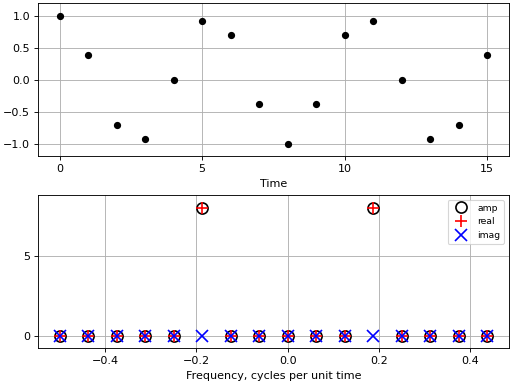

(<Figure size 512x384 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time'>,
        <AxesSubplot:xlabel='Frequency, cycles per unit time'>],
       dtype=object))

In [49]:
npts = 16
sinusoid(npts=npts, cycles=3)

What happens if the signal frequency is above the Nyquist frequency?

<IPython.core.display.Javascript object>


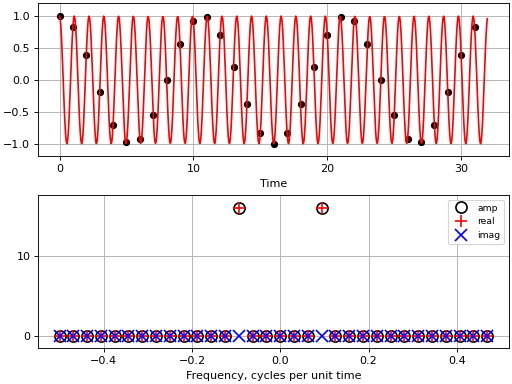

In [50]:
npts = 32
cycles = npts - 3
fig, axs = sinusoid(npts=npts, cycles=cycles)
dt = 0.05  #  Resolve the aliased curve
x, y = sinusoid_pts(npts=npts/dt, cycles=cycles, dt=dt)
axs[0].plot(x, y, 'r')

Notice that we do indeed have a simple cosine curve with 3 cycles within the record of length 32 points.  The transform has zero imaginary part, and the real part is symmetric about zero frequency, as expected.  Because we chose an integral number of cycles per record length, which is one of the Fourier frequencies, there is only one positive frequency with a non-zero amplitude, and it is of course the third one above zero.

Now try giving it a phase shift of 0.25 cycle:

<IPython.core.display.Javascript object>


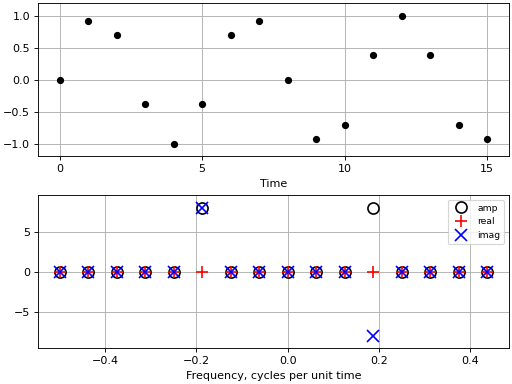

(<Figure size 512x384 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time'>,
        <AxesSubplot:xlabel='Frequency, cycles per unit time'>],
       dtype=object))

In [51]:
sinusoid(phase=0.25)

That changed the curve from a cosine into a sine.  Now the transform has no non-zero *real* part. Its imaginary part is antisymmetric about zero frequency, and is non-zero only for 3 cycles per record length, as expected.

What happens if the time series is a cosine, but has a non-integer number of cycles per record length?

<IPython.core.display.Javascript object>


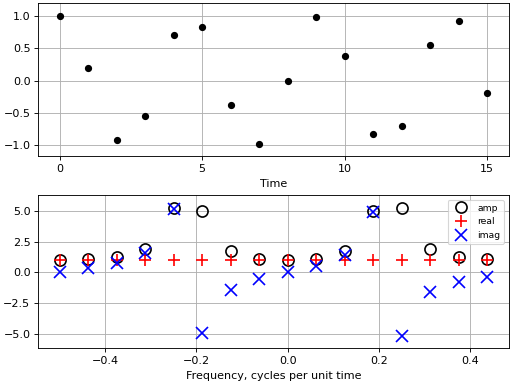

(<Figure size 512x384 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time'>,
        <AxesSubplot:xlabel='Frequency, cycles per unit time'>],
       dtype=object))

In [52]:
sinusoid(cycles=3.5)

The largest amplitudes are at 3 and 4 cycles per record length, as expected, but now there are non-zero real and imaginary amplitudes at *all* frequencies.  This is the phenomenon of *leakage*, and it is fundamental to the Fourier transform and to all data analysis techniques based on it.

<IPython.core.display.Javascript object>


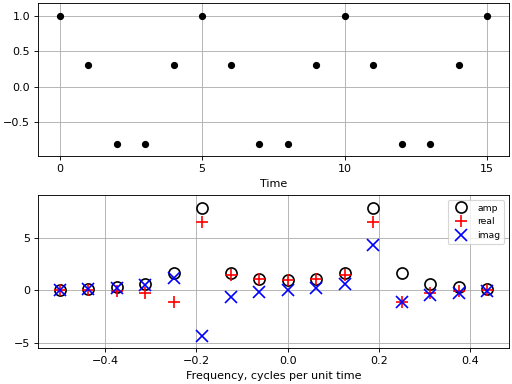

(<Figure size 512x384 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time'>,
        <AxesSubplot:xlabel='Frequency, cycles per unit time'>],
       dtype=object))

In [53]:
sinusoid(cycles=3.2)

Now the signal is closer to a Fourier frequency, and the largest amplitude is at that nearest frequency, 3 cycles per record length.  The distribution of real and imaginary parts of the amplitude is more complicated than in the previous example, but still shows the expected symmetry: $H_n = H^*_{-n} \:$.

Try complex input, a complex exponential at 3 cycles per record length rotating counter-clockwise:

<IPython.core.display.Javascript object>


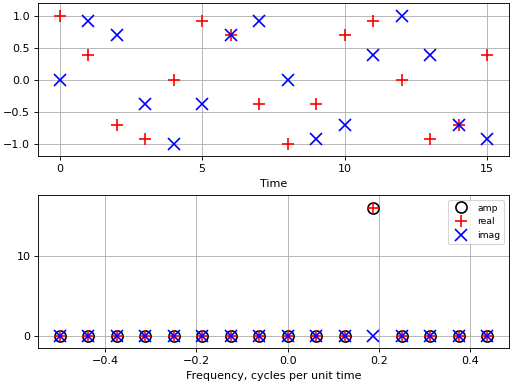

(<Figure size 512x384 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time'>,
        <AxesSubplot:xlabel='Frequency, cycles per unit time'>],
       dtype=object))

In [54]:
sinusoid(rotation='positive')

And rotating clockwise:

<IPython.core.display.Javascript object>


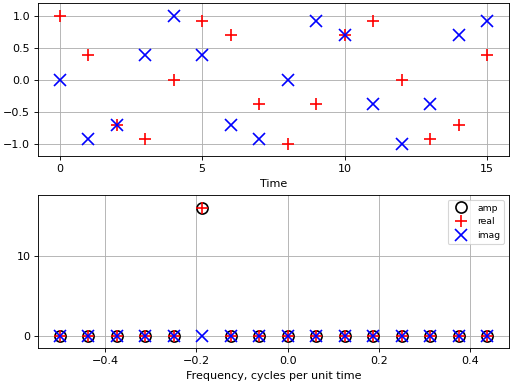

(<Figure size 512x384 with 2 Axes>,
 array([<AxesSubplot:xlabel='Time'>,
        <AxesSubplot:xlabel='Frequency, cycles per unit time'>],
       dtype=object))

In [55]:
sinusoid(rotation='negative')

Notice the expected phase relationship between the real and imaginary parts of the input, and the isolation of the Fourier transform to a single non-zero amplitude, at a positive frequency for counter-clockwise rotation, and at a negative frequency for clockwise rotation.

### Transform of a pulse

We have seen that the FT of a sinusoid is highly peaked--that is, it is localized in frequency space, even though some energy is spread by leakage.  In the ideal case, where the sinusoid being sampled has an integral number of cycles per record length, the FT is a single spike (or two spikes, if we treat positive and negative frequencies separately.)  What happens when the signal is peaked (highly localized) in the *time* domain?   Let's look at the FT of a pulse of variable width and location:

In [56]:
def pulse(npts = 32, uplims=None, dt=1):
    """
    Generate and display a pulse signal and its transform.
    """
    x1 = np.arange(npts, dtype=float) * dt
    y1 = np.zeros_like(x1)
    if uplims is None:
        upslice = slice(0, npts // 2)
    else:
        upslice = slice(*uplims)
    y1[upslice] = 1    
    show_transform(x1, y1)


Try a pulse at the origin--a single non-zero point:

<IPython.core.display.Javascript object>


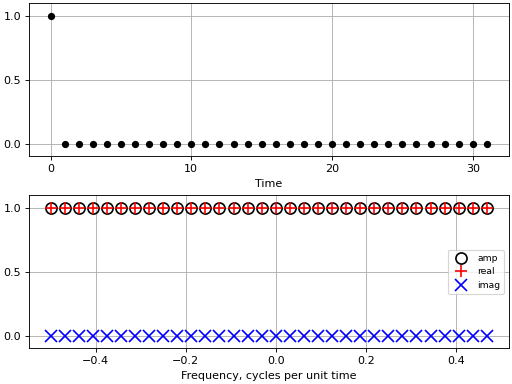

In [57]:
pulse(uplims=[0, 1])

Shift the raised point to the right:

<IPython.core.display.Javascript object>


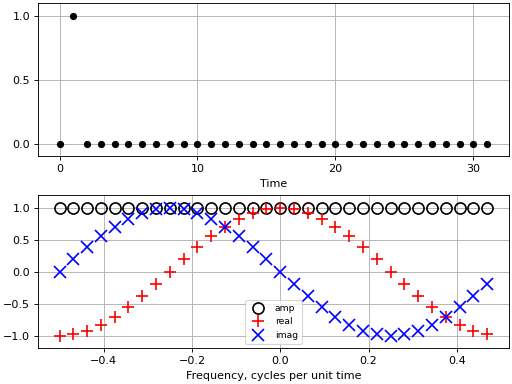

In [58]:
pulse(uplims=[1,2])

Notice that although the transforms of these two very similar signals look quite different, they actually differ only in phase; in both cases, the magnitude of the complex amplitude is uniform with frequency.  *The most extreme localization in the time domain produces the most complete uniformity in the frequency domain.*

Now try a wider pulse:

<IPython.core.display.Javascript object>


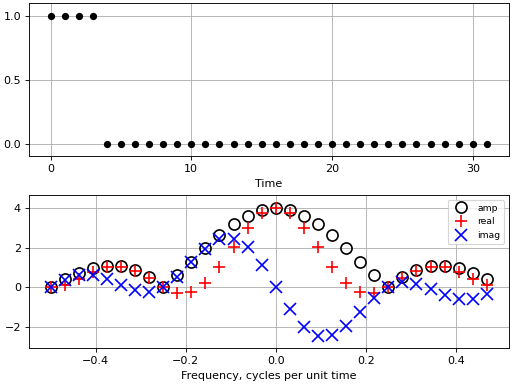

In [59]:
pulse(uplims=[0,4])

<IPython.core.display.Javascript object>


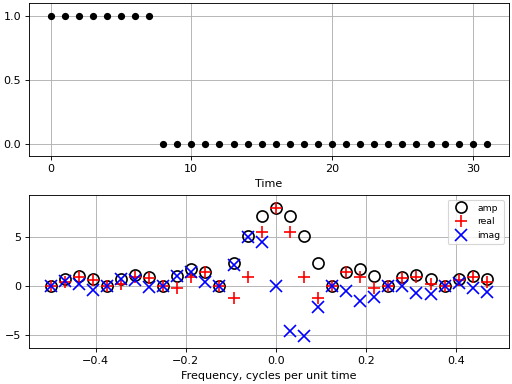

In [60]:
pulse(uplims=[0, 8])

<IPython.core.display.Javascript object>


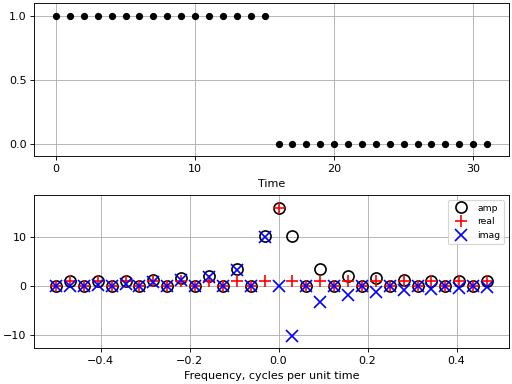

In [61]:
pulse(uplims=[0, 16])


With a wider pulse--less localized in space--the frequency range with large amplitude gets narrower.

### Transform of noise

We noted in the beginning that the FT is particularly useful for analyzing noise-like time series, with no obvious periodicity.  In such cases, we are usually interested in knowing the spectral character of the data, often described with an analogy to the visual spectrum.  A white time series is one with roughly uniform variance per unit frequency; a red spectrum is weighted towards low frequencies; and a blue spectrum is weighted toward high frequencies.

In [62]:
def noise(npts = 32, color='w', dt=1, repeatable=True):
    """
    Generate and display a noise signal and its transform.
    
    Color may be 'r', 'w', or 'b'.

    To experiment with different sets of pseudo-random numbers,
    set *repeatable* to *False*.
    """
    if repeatable:
        np.random.seed(0)
    x1 = np.arange(npts, dtype=float) * dt
    y1 = np.random.randn(npts + 1)
    if color == 'w':
        y1 = y1[:npts]
    elif color == 'r':
        y1 = y1.cumsum()[:npts]
    elif color == 'b':
        y1 = np.diff(y1)
    y1 -= y1.mean()    
    show_transform(x1, y1)


For each of the following, change the `repeatable` kwarg to `'False'` and run the cell repeatedly to see how the results change with each realization of the random process.

<IPython.core.display.Javascript object>


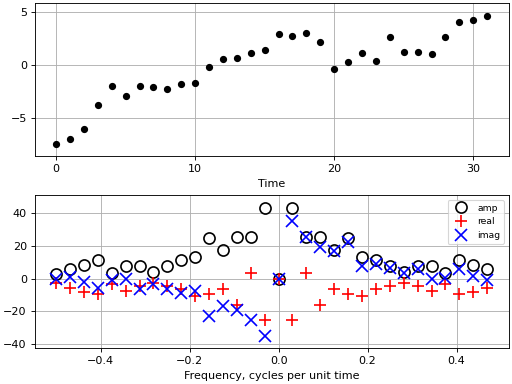

In [63]:
noise(color='r', repeatable=True)


<IPython.core.display.Javascript object>


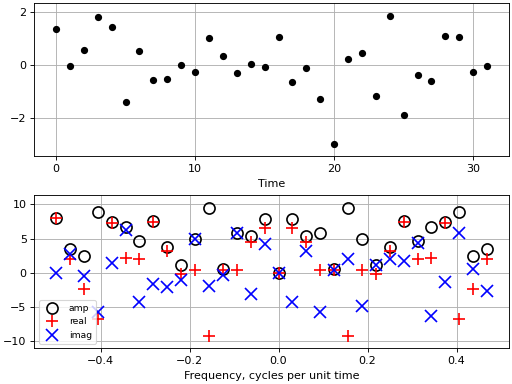

In [64]:
noise(color='w', repeatable=True)

<IPython.core.display.Javascript object>


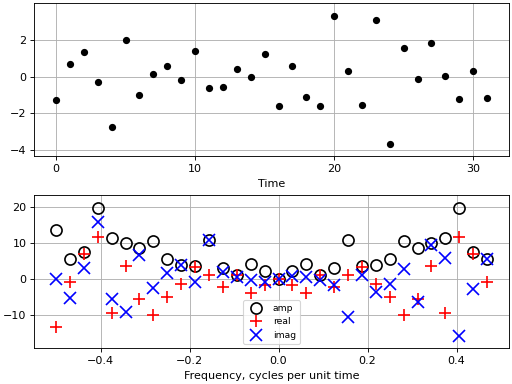

In [65]:
noise(color='b')

From the three examples above, progressing from red to white to blue, you can see the change in amplitude distributions, from emphasizing low frequencies, to uniform, to emphasizing high frequencies.  Because we are working with random samples, the FT values are also random.

### Transform of a trend

In [66]:
def trend(npts = 32, dt=1):
    """
    Generate and display a linear trend and its transform.
    """
    x1 = np.arange(npts, dtype=float) * dt
    y1 = np.arange(npts, dtype=float)
    y1 -= y1.mean()
    
    show_transform(x1, y1)


<IPython.core.display.Javascript object>


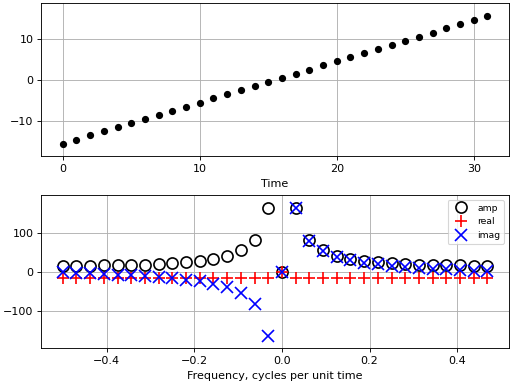

In [67]:
trend()

## Inverse transform

Apart from floating point truncation error, the inverse FT reverses the action of the FT.  We can put a step in the middle, however, to attenuate or remove the energy at some frequencies, thereby filtering the signal.  We will illustrate this here using a sharp low-pass cutoff.  The pulse will be the first guinea pig.  The effect of the sharp cutoff will be more clear with a longer time series, hence the choice of 256 points.

In [68]:
def pulse_signal(npts = 256, uplims=None, dt=1):
    """
    Generate and return a pulse signal.
    """
    x1 = np.arange(npts, dtype=float) * dt
    y1 = np.zeros_like(x1)
    if uplims is None:
        upslice = slice(0, npts // 2)
    else:
        upslice = slice(*uplims)
    y1[upslice] = 1    
    return x1, y1



In [69]:
def reconstruct(y, cutoff=None):
    """
    Reconstruct a time series via the ifft of its fft, optionally cutting
    out frequencies at and above a threshold.

    cutoff is the lowest frequency in integer cycles per record length
    that is to be omitted in the reconstruction.
    """
    y = np.asarray(y)
    npts = len(y)
    fy = fft(y)
    if cutoff is not None:
        if cutoff > 1:
            fy[cutoff:-(cutoff-1)] = 0
        else:
            raise ValueError("cutoff must be greater than 1")
    yr = ifft(fy)
    if y.dtype.kind == 'c':
        return yr
    return yr.real       

In [70]:
def show_pulse_reconstruction(cutoffs, **kw):
    """
    cutoffs must be a list of cutoff frequencies in cycles per record length
    """
    x, y = pulse_signal(**kw)
    yrs = np.zeros((len(x), len(cutoffs)), dtype=float)
    for i, cutoff in enumerate(cutoffs): 
        yrs[:, i] = reconstruct(y, cutoff=cutoff)
    fig, ax = plt.subplots()
    line0 = ax.plot(x, y, color='k', lw=3)
    lines = ax.plot(x, yrs)
    linelist = line0 + lines
    labels = ["orig"]
    labels += ["%s" % c for c in cutoffs]
    ax.legend(linelist, labels)
    ax.grid(True)
    ax.set_xlabel('Time')
    ax.set_title('Truncated Fourier series')
    


<IPython.core.display.Javascript object>


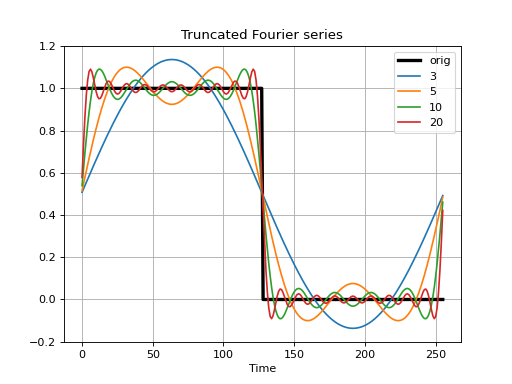

In [71]:
show_pulse_reconstruction([3, 5, 10, 20])

Notice that the reconstruction improves as we move the cutoff out to higher frequencies, but it always oscillates about its target.  Is there a better way to filter using the FFT and IFFT?

Instead of using a sharp cutoff, let's try tapering down to zero.

In [72]:
def reconstruct2(y, cutoff=None, taperfrac=0.25):
    """
    Reconstruct a time series via the ifft of its fft, optionally cutting
    out frequencies at and above a threshold.

    cutoff is about half-way down the slope of the taper.
    """
    y = np.asarray(y)
    npts = len(y)
    fy = fft(y)
    if cutoff is not None:
        if cutoff > 1:
            w = np.ones((npts,), dtype=float)
            ntaper = int(round(taperfrac * cutoff))
            ntaper = min(cutoff - 2, ntaper)
            w[cutoff + ntaper:-(cutoff + ntaper - 1)] = 0
            w[cutoff - ntaper:cutoff + ntaper + 1] = np.linspace(1, 0, num=2 * ntaper + 1)
            w[-cutoff - ntaper:-cutoff + ntaper + 1] = np.linspace(0, 1, num=2 * ntaper + 1)
        else:
            raise ValueError("cutoff must be greater than 1")
    yr = ifft(fy * w)
    if y.dtype.kind == 'c':
        return yr, w
    return yr.real, w       

In [73]:
def show_pulse_reconstruction2(cutoffs, taperfrac=0.25, **kw):
    """
    cutoffs must be a list of cutoff frequencies in cycles per record length
    """
    x, y = pulse_signal(**kw)
    yrs = np.zeros((len(x), len(cutoffs)), dtype=float)
    for i, cutoff in enumerate(cutoffs): 
        yrs[:, i] = reconstruct2(y, cutoff=cutoff, taperfrac=taperfrac)[0]
    fig, ax = plt.subplots()
    line0 = ax.plot(x, y, color='k', lw=3)
    lines = ax.plot(x, yrs)
    linelist = line0 + lines
    labels = ["orig"]
    labels += ["%s" % c for c in cutoffs]
    ax.legend(linelist, labels)
    ax.grid(True)
    ax.set_xlabel('Time')
    ax.set_title('Tapered Fourier series')
    


<IPython.core.display.Javascript object>


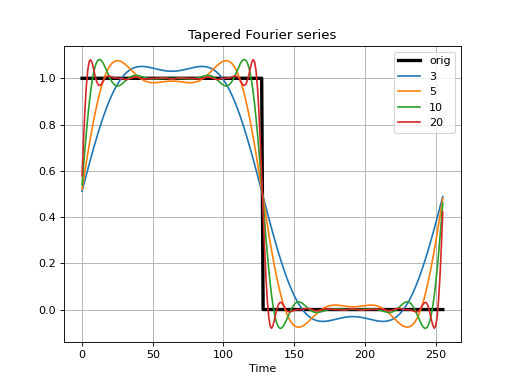

In [74]:
show_pulse_reconstruction2([3, 5, 10, 20])

<IPython.core.display.Javascript object>


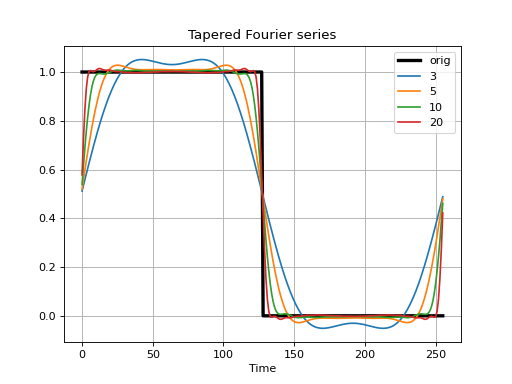

In [75]:
show_pulse_reconstruction2([3, 5, 10, 20], taperfrac=0.75)

We used a very crude tapering, but it still helps suppress the wiggles.

# Section 3
## Spectral Analysis
We are familiar with thinking about light in terms of its color content, and sound, especially music, in terms of its frequency content.  We do the same with geophysical time series--we describe them, break them up, or filter them based on frequency.  More generally, this can be extended to the spatial dimensions.  The spectrum of ocean surface gravity waves can be described in terms of wavelength or wavenumber, although this brings in the additional complication that wavenumber is a vector whereas frequency is a scalar.  In any case, we are working with the way energy is distributed among periodic components, and so long as we are considering only a single variable, we care about energy or amplitude, but not about phase.  This is a central point: the autospectrum, which is the topic of this notebook, *discards information about phase*.

Note: in all of the following we are making quick plots in script fashion, with no attempt to add the usual niceties such as axis labels and legends.  These plots are intended for your experimentation, not as examples of a product one would use for other than such tutorial purposes.  Time scales are in days, frequencies are in cycles per day, given hourly data. Power spectral density is in amplitude squared per cycle per day.

In [76]:
%matplotlib inline 
# substitude notebook for inline above to get interactive
# inline plots

import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as ss

plt.rcParams['figure.dpi'] = 90

In [77]:
def datafaker(nt, dt=1, freqs=None, color='w',
              amp=1, 
              complex=True,
              repeatable=True):
    """
    Generate fake data with optional sinusoids (all the
    same amplitude) and with red, white, or blue noise
    of arbitrary amplitude.
    
    *nt* : number of points
    *dt* : time increment in arbitrary time units
    *freqs* : None, or a sequence of frequencies in
        cycles per unit time. 
    *color* : 'r', 'w', 'b'
    *amp* : amplitude of red, white, or blue noise
    *complex* : True, False
    *repeatable* : True, False

    Returns t, x
    """
    if repeatable:
        np.random.seed(1)    
    noise = np.random.randn(nt + 1) + 1j * np.random.randn(nt + 1)
    
    if color == 'r':
        noise = np.cumsum(noise) / 10 
        noise -= noise.mean()
    elif color == 'b':
        noise = np.diff(noise)
    noise = noise[:nt]
    x = amp * noise

    t = np.arange(nt, dtype=float) * dt
    
    for f in freqs:
        sinusoid = np.exp(2 * np.pi * 1j * f * t)
        x += sinusoid
    if not complex:
        x = np.real(x)
        
    return t, x

Let's try hourly data, real (as opposed to complex), with a strong semidiurnal tide plus red noise.

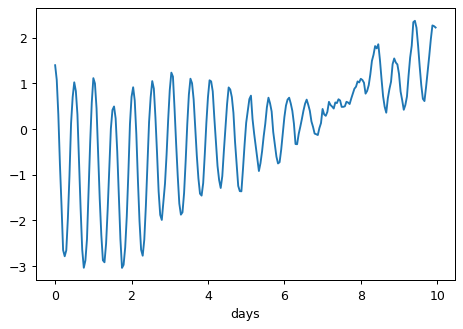

In [78]:
nt = 240

dt = 1/24 # 1 hour sample interval
tides = [24/12.42, 24/12]

t, h = datafaker(nt, dt=dt, freqs=tides, amp=1, 
                 color='r',
                 complex=False)
fig, ax = plt.subplots()
ax.plot(t, h)
ax.set_xlabel('days');

The starting point for the autospectrum is the discrete Fourier transform.  The squared amplitudes--discarding the phase--gives a raw periodogram. We are starting with a real series, so we don't need both the positive and the negative frequencies. We could use `np.fft.rfft` which only calculates the positive frequencies, but since we will be working with complex inputs later, we will instead use `np.fft.fft` for everything, and sacrifice some efficiency.

In [79]:
def spectrum1(h, dt=1):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw


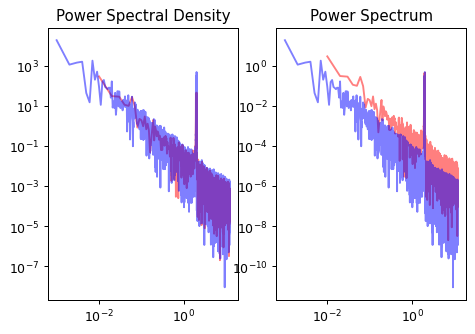

In [80]:
# Pick two data lengths as number of samples.  These will be used
# throughout the following examples.  They need to be quite large
# for the examples to work well.
n1 = 2400
n2 = 24000

dfkw = dict(dt=dt, freqs=tides, amp=1, color='r', complex=False)

t, h1 = datafaker(n1, **dfkw)
freqs1, ps1, psd1 = spectrum1(h1, dt=dt)

t, h2 = datafaker(n2, **dfkw)
freqs2, ps2, psd2 = spectrum1(h2, dt=dt)

fig, axs = plt.subplots(ncols=2, sharex=True)
axs[0].loglog(freqs1, psd1, 'r',
              freqs2, psd2, 'b', alpha=0.5)
axs[1].loglog(freqs1, ps1, 'r', 
              freqs2, ps2, 'b', alpha=0.5)
axs[0].set_title('Power Spectral Density')
axs[1].set_title('Power Spectrum')
axs[1].axis('tight');

Given a time series of $N$ points, $h_j$, and the corresponding $N$ Fourier Transform coefficients, $H_k$, then Parseval's Theorem can be written as
$$\frac{1}{N}\sum_j |h_j|^2 = \frac{1}{N^2} \sum_k |H_k|^2.$$
This is why, in `spectrum1`, we divide each $|H_k|^2$ by $N^2$ to get the Power Spectrum (PS)---so that the value of the PS at each frequency will be the contribution of that frequency to the total *variance* in the time series.

Check this for our example; note that `spectrum1` is discarding the mean, consistent with the use of the `var` method of the time series.  It is also discarding the Nyquist, however, so we lose a tiny bit of the variance.


In [81]:
print('PS sum:   %.2f, %.2f' % (ps1.sum(), ps2.sum()))
print('Variance: %.2f, %.2f' % (h1.var(), h2.var()))
print('Differences: %g, %g' % (h1.var() - ps1.sum(),
                               h2.var() - ps2.sum()))

PS sum:   5.45, 29.10
Variance: 5.45, 29.10
Differences: 8.23172e-07, 2.45391e-08


Notice that for the tidal peaks, the PS preserves the amplitude while the PSD preserves the integral, but not the amplitude.  For the background noise, their roles are reversed: the spectral level is preserved by the PSD, but not by the PS.

To get stable numbers in the calculations above requires sufficiently long time series, hence the choice of 2400 and 24000 hours.

Now, why do we get a PSD integral over the tide band of approximately 1, and PS max values of 0.5?  Recall that our fake tide is being generated with two sinusoids of unit amplitude.  The variance contributed by each is 0.5, hence the PS max value.  Integrating over the tidal band we have the sum of the two variances, hence 1.